# BAN 5753 Ensemble Learning Exercise


In [53]:
# import all necessary libraries
import pandas as pd
import os
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping
import shap
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
#rcParams['figure.figsize']=16,15
rcParams.update({'font.size': 14})
# pd.options.display.max_columns = 25
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from numpy import argmax
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, average_precision_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

## Data Preprocessing

In [54]:
# load data set
df = pd.read_csv("C:\\Users\\cwolt\\OneDrive\\Desktop\\BAnDS\\Fall 2025\\Advanced Business Analytics\\Module 3\\HW\\hospital_admissions_with_missing.csv")
print(df.head())
print(df.dtypes)

   Admitted  avg_income  CLINIC_VISIT REFERRAL_SOURCE  Visit_Date Visit_Month  \
0         0    46045.39             0              ER           4         Jan   
1         0    19145.43             1            Self           4         Sep   
2         0    48816.69             0            Self           9         Oct   
3         0    68702.11             0              ER           8         Mar   
4         1    63064.45             0            Self           2         Sep   

   Visit_Year  distance_to_hospital ETHNICITY   BMI  Patient_ID  \
0        2024                 11.40     Asian  35.2       10001   
1        2025                  5.20     White  26.3       10002   
2        2023                  2.67       NaN  25.2       10003   
3        2024                 13.27     White  26.9       10004   
4        2024                 14.49     Black  37.9       10005   

   symptom_duration Local_Resident    BP_Score  Pulse_Score  \
0                 9              Y  120.417310 

### Drop Unnecessary Variables

In [55]:
# a. Drop unnecessary variables (Visit_Year, Patient_ID, PRIOR_PROVIDER_TYPE, TOTAL, AllocProportion, SampleSize, ActualProportion, SelectionProb, and SamplingWeight)
df = df.drop(columns=['Visit_Year', 'Patient_ID', 'PRIOR_PROVIDER_TYPE', 'TOTAL', 'AllocProportion', 'SampleSize', 'ActualProportion', 'SelectionProb', 'SamplingWeight'])
print(df.head())
print(df.dtypes)

   Admitted  avg_income  CLINIC_VISIT REFERRAL_SOURCE  Visit_Date Visit_Month  \
0         0    46045.39             0              ER           4         Jan   
1         0    19145.43             1            Self           4         Sep   
2         0    48816.69             0            Self           9         Oct   
3         0    68702.11             0              ER           8         Mar   
4         1    63064.45             0            Self           2         Sep   

   distance_to_hospital ETHNICITY   BMI  symptom_duration Local_Resident  \
0                 11.40     Asian  35.2                 9              Y   
1                  5.20     White  26.3                 6              Y   
2                  2.67       NaN  25.2                 8              Y   
3                 13.27     White  26.9                 5              Y   
4                 14.49     Black  37.9                13              N   

     BP_Score  Pulse_Score  interest_in_admission INSURA

### Encode Cyclical features

In [56]:
# b. encode ciclical features (Visit_Month, Visit_Date)
# Handle Visit_Month: convert strings like 'Jul' to integers using mapping
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Convert month strings to numeric
df['Visit_Month'] = df['Visit_Month'].map(month_map)

# error caused* Drop rows where mapping failed (e.g., invalid month names)
df = df[df['Visit_Month'].notna()]

# Cyclical encoding for Visit_Month
df['Visit_Month_sin'] = np.sin(2 * np.pi * df['Visit_Month'] / 12)
df['Visit_Month_cos'] = np.cos(2 * np.pi * df['Visit_Month'] / 12)

# Drop Visit_Month now that it's encoded
df.drop(columns=['Visit_Month'], inplace=True, errors='ignore')


# Handle Visit_Date
df['Visit_Date'] = pd.to_datetime(df['Visit_Date'], errors='coerce')

# Drop rows with invalid or missing dates
df = df[df['Visit_Date'].notna()]

# Extract day of month
df['Visit_Day'] = df['Visit_Date'].dt.day
df['Visit_Day_sin'] = np.sin(2 * np.pi * df['Visit_Day'] / 31)
df['Visit_Day_cos'] = np.cos(2 * np.pi * df['Visit_Day'] / 31)

# Extract weekday (0=Mon to 6=Sun)
df['Visit_Weekday'] = df['Visit_Date'].dt.weekday
df['Visit_Weekday_sin'] = np.sin(2 * np.pi * df['Visit_Weekday'] / 7)
df['Visit_Weekday_cos'] = np.cos(2 * np.pi * df['Visit_Weekday'] / 7)

# Drop raw datetime columns and intermediate features
df.drop(columns=['Visit_Date', 'Visit_Day', 'Visit_Weekday'], inplace=True, errors='ignore')


### Encode Local_Resident column to int

In [57]:
# c. Encode Local_Resident column to integer Values.
df['Local_Resident'] = df['Local_Resident'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

### Extra Credit: Handle Missing Values in Dataset

In [58]:
# d. Extra Credit: Handle the missing values in the dataset
# Check for missing values
print(df.isnull().sum())


Admitted                   0
avg_income                75
CLINIC_VISIT               0
REFERRAL_SOURCE           60
distance_to_hospital       0
ETHNICITY                 60
BMI                       75
symptom_duration           0
Local_Resident             0
BP_Score                   0
Pulse_Score                0
interest_in_admission      0
INSURANCE_TYPE             0
FOLLOWUP_EMAILS            0
REFERRED_BY_SPECIALIST     0
REFERRAL_CONTACTS          0
OXYGEN_LEVEL              75
PATIENT_CALLS              0
sex                        0
HOSPITAL_REACHOUTS         0
TELEMEDICINE_SCORE         0
SERVICE_REGION             0
TOTAL_CONTACTS             0
TRAVEL_REQUESTS            0
Visit_Month_sin            0
Visit_Month_cos            0
Visit_Day_sin              0
Visit_Day_cos              0
Visit_Weekday_sin          0
Visit_Weekday_cos          0
dtype: int64


In [59]:
# Fill missing values with appropriate strategies
# Variables with missing values:avg_income, referral_source, Ethnicity, BMI, Oxygen_level
df['avg_income'].fillna(df['avg_income'].median(), inplace=True)  # Fill with median
df['REFERRAL_SOURCE'].fillna(df['REFERRAL_SOURCE'].mode()[0], inplace=True)  # Fill with mode
df['ETHNICITY'].fillna(df['ETHNICITY'].mode()[0], inplace=True)  # Fill with mode
df['BMI'].fillna(df['BMI'].median(), inplace=True)  # Fill with median
df['OXYGEN_LEVEL'].fillna(df['OXYGEN_LEVEL'].median(), inplace=True)  # Fill with median
# Check for missing values post_imputation
print(df.isnull().sum())


Admitted                  0
avg_income                0
CLINIC_VISIT              0
REFERRAL_SOURCE           0
distance_to_hospital      0
ETHNICITY                 0
BMI                       0
symptom_duration          0
Local_Resident            0
BP_Score                  0
Pulse_Score               0
interest_in_admission     0
INSURANCE_TYPE            0
FOLLOWUP_EMAILS           0
REFERRED_BY_SPECIALIST    0
REFERRAL_CONTACTS         0
OXYGEN_LEVEL              0
PATIENT_CALLS             0
sex                       0
HOSPITAL_REACHOUTS        0
TELEMEDICINE_SCORE        0
SERVICE_REGION            0
TOTAL_CONTACTS            0
TRAVEL_REQUESTS           0
Visit_Month_sin           0
Visit_Month_cos           0
Visit_Day_sin             0
Visit_Day_cos             0
Visit_Weekday_sin         0
Visit_Weekday_cos         0
dtype: int64


In [60]:
# group columns for easier use later during modeling process
binary = ['CLINIC_VISIT', 'REFERRED_BY_SPECIALIST', 'Local_Resident', 'sex']
nominal = ['REFERRAL_SOURCE', 'ETHNICITY', 'INSURANCE_TYPE', 'SERVICE_REGION']
ordinal = ['interest_in_admission']
cyclical = ['Visit_Date', 'Visit_Month']
numeric = [
    'avg_income', 'distance_to_hospital', 'BMI', 'symptom_duration',
    'BP_Score', 'Pulse_Score', 'FOLLOWUP_EMAILS', 'REFERRAL_CONTACTS',
    'OXYGEN_LEVEL', 'PATIENT_CALLS', 'HOSPITAL_REACHOUTS',
    'TELEMEDICINE_SCORE', 'TOTAL_CONTACTS', 'TRAVEL_REQUESTS'
]


## Use 70-30 Split for Training and Validation

In [61]:
# 3. Use 70-30 split for training and validation sets.
# Define target and features
target = 'Admitted'
X = df.drop(columns=[target])
y = df[target]

# Split the data: 70% train, 30% validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.3,
    random_state=12345,        # wanted to create a seed so that I can reproduce the results for each model
    stratify=y            # wanted to stratify based on target variable  
)

In [62]:
# taken from demo_RF-LightGBM 
# Class for MultiColumn Label Encoding. Sklearn's LabelEncoding class can't handle multiple variables at a time
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

## Random Forest Model

### Encode Categorical variables using catboost

In [63]:
# 4. Build a Random Forest model to predict the target variable (Admitted).
# a. Encode categorical variables using CatBoost encoding
rf_model = RandomForestClassifier(random_state=12345, class_weight='balanced')

pipeline = Pipeline([
    ('catboost', CatBoostEncoder(cols=nominal, random_state=12345)),
    ('rf', rf_model)
])

### use grid search to choose the best parameters

In [64]:
# b. choose best hyperparameters using grid search with 5-fold cross-validation
param_grid = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [5, 10, 15],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}


The best hyperparameters are shown above
#### Explanation:
n_estimators: This hyperparameter specifies the number of trees to be used in the forest model for best results. The best model chose to use 300 decision trees which will improve robustness of our model

max_depth: This dictates the maximum depth of each decision tree (number of splits or levels of a tree). In our best model we used a depth of 15 which is the maximum option available. This by itself is not cause for concern. However, we want to ensure that our model is not overfitting to the data.

min_samples_split: This specifies the minimum number of samples required to split a branch. This will help with preventing overfitting as well. In the best model, we had a minimum sample split of 5

min_samples_leaf: Similar to min_samples_split, min_samples_leaf is the minimum number of samples required at a leaf node. This also helps prevent overfitting by requiring each leaf to represent a subset of data. In the best model, the minimum samples required was 1

max_features: this hyperparameter tells us the number of features to consider when looking for the best split. With option of 'sqrt'= square root of total features or 'log2' = log base 2 of total features. The best model chose 'sqrt' which helps balance the randomness in our model.

Best Random Forest AUC Score: 0.9944
Best Hyperparameters: {'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}


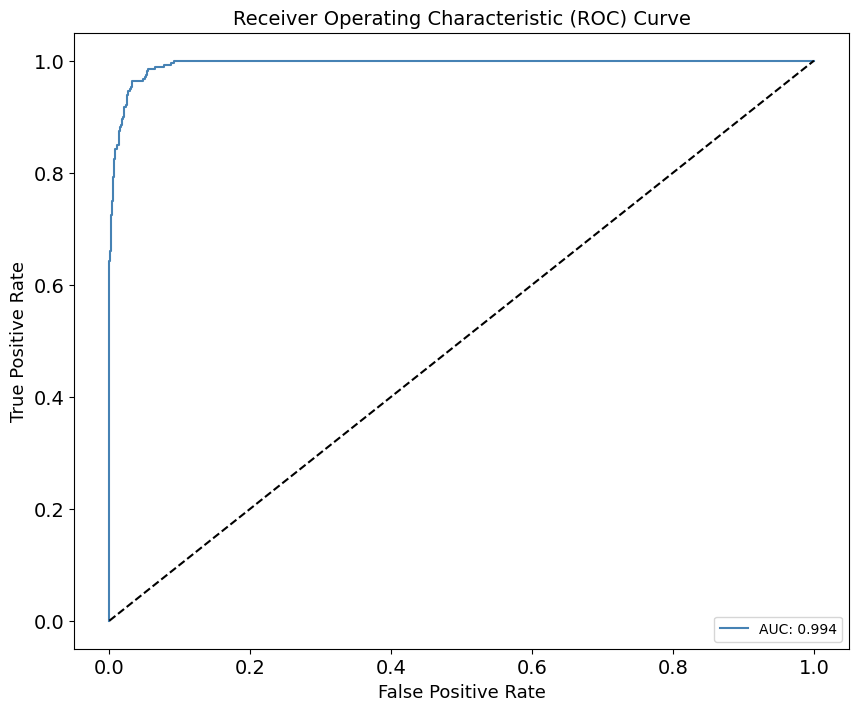

In [65]:
# Predict probabilities
y_probs = best_rf_model.predict_proba(X_valid)[:, 1]

# Compute ROC
fpr, tpr, _ = roc_curve(y_valid, y_probs)
auc_score = roc_auc_score(y_valid, y_probs)

# Plot ROC Curve
#Function for Plotting ROC Curve
def plot_roc_curve(fpr, tpr, auc):
    f, ax = plt.subplots(figsize=(10, 8))
    plt.plot(fpr, tpr, color='steelblue', label='ROC')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(['AUC: %.3f' % auc], fontsize=10)
#plt.show()
plot_roc_curve(fpr, tpr, auc_score)

# Report
print("Best Random Forest AUC Score:", round(auc_score, 4))
print("Best Hyperparameters:", grid_search.best_params_)


#### Roc plot results
The ROC curve shows us that we have an AUC = 0.9944 which is phenominal for a predictive model. This tells us that our model is effective in distiguishing between the target class and that the model significantly outperforms random guessing as well.

## LightGBM Classifier

### Encode Categorical variables using in-built LightGBM categorical feature conversion

In [66]:
# a. lightGBM encoder for categorical variables
# Define list of categorical columns
cat_features = nominal 

# Convert these to 'category' dtype
X_train[cat_features] = X_train[cat_features].astype('category')
X_valid[cat_features] = X_valid[cat_features].astype('category')


### Choose best hyperparameters

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Info] Number of positive: 653, number of negative: 2847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1688
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

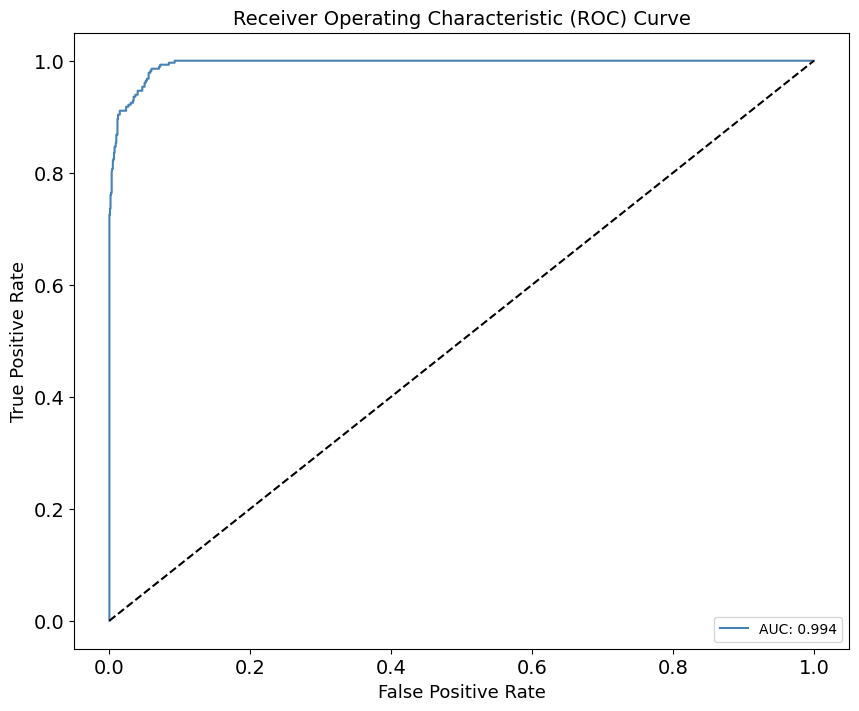

In [67]:
# b. choose best hyperparameters using grid search with 5-fold cross-validation
# Define base model
lgb_model = lgb.LGBMClassifier(random_state=12345, class_weight='balanced')

# hyperparameter grid
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10, -1],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 64],
    'reg_alpha': [0, 1],
    'reg_lambda': [0, 1]
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# Grid Search with AUC as scoring
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train, categorical_feature=cat_features)

# best model and parameters
print("Best LightGBM AUC Score (CV):", round(grid_search.best_score_, 4))
print("Best Hyperparameters:", grid_search.best_params_)
    
best_params = grid_search.best_params_
LM = lgb.LGBMClassifier(
    **best_params,
    random_state=12345,
    objective='binary',
    class_weight='balanced',
    boosting_type='gbdt',
    metric='auc'
)

LM.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=10)],
    categorical_feature=cat_features,
)

# Evaluate model
predictprob_val_LM = LM.predict_proba(X_valid)[:, 1]
prediction_val_LM = LM.predict(X_valid)

auc_LM = roc_auc_score(y_valid, predictprob_val_LM)
print(f"Final AUC on Validation Set: {auc_LM:.3f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_valid, predictprob_val_LM)
plot_roc_curve(fpr, tpr, auc_LM)

### Explanation of Hyperparameters:
The first two hyperparameters are the same as in the Random Forest model:

n_estimators: This hyperparameter specifies the number of trees to be used in the forest model for best results. The best model chose to use 300 decision trees which will improve robustness of our model

max_depth: This dictates the maximum depth of each decision tree (number of splits or levels of a tree). In our best model we used a depth of -1 which is no limit. We want to ensure that our model is not overfitting to the data.

These are the new/different hyperparameters used for the LightGBM model:
Learning_rate: specifies how fast or slow a model can learn. This helps prevent overfitting by making small updates to correct errors rather than massive adjustments. The best model had a learning rate = 0.01

num_leaves: This specifies the maximum number of leaver per tree. Our best model set the num_leaves = 31. This is about average and helps control the model and prevent overfitting when considering there is no maximum depth

reg_alpha & reg_labmda: these are regularization parameters. In our best model they were both set to 0 meaning there is no penalty on the model weights.

### Comparison to RF model:
Both of the models demonstrated very high performance, each achieving an AUC of 0.994 on the validation set. This score tells us that both models are nearly perfect at distinguishing between the positive and negative classes. While their predictive power is effectively identical based on AUC, the LightGBM model has practical advantages. It reached this performance in just 66 boosting iterations due to early stopping, making it significantly more efficient in terms of computation compared to the Random Forest model, which required all 300 trees. Additionally, LightGBM is optimized for speed and memory usage and natively supports categorical features when specified properly. LightGBM would likely be the preferred model for deployment.

## XGBoost Classifier

### Encode Categorical variables using in-build XGBoost

In [68]:
# a. encode catergorical variables (already done above)
# Encode categorical features using CatBoostEncoder
encoder = CatBoostEncoder(cols=cat_features, random_state=123)
X_train_enc = encoder.fit_transform(X_train, y_train)
X_valid_enc = encoder.transform(X_valid)


### Choose best hyperparameters and create 

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best XGBoost AUC Score (CV): 0.9956
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Final AUC on Validation Set: 0.995


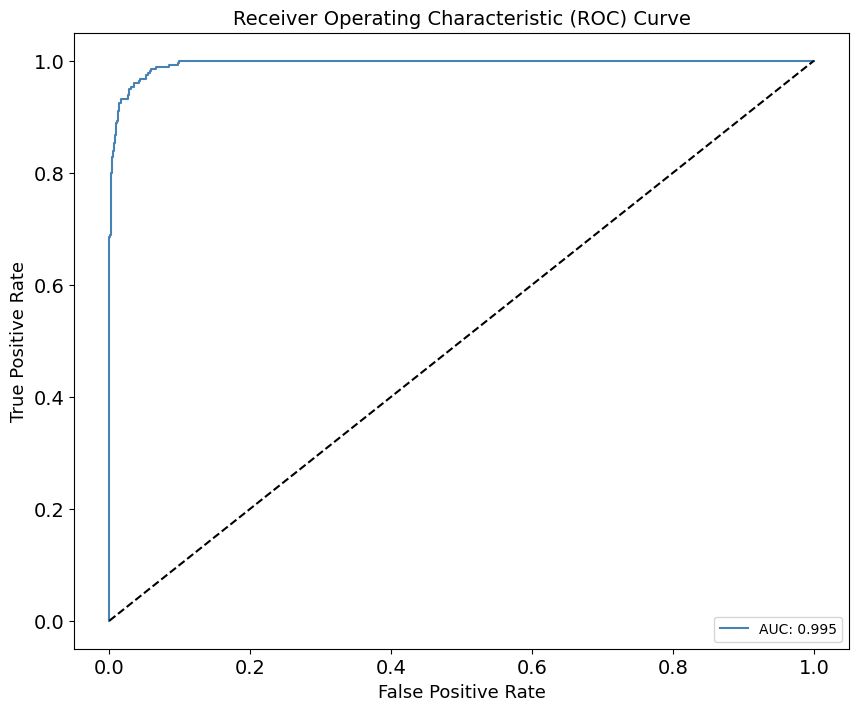

In [ ]:
# b. use grid search with 5-fold cross-validation to choose best hyperparameters
# Define base model
xgboost_model = xgb.XGBClassifier(random_state=12345, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train==0).sum()/(y_train==1).sum())

# hyperparameter grid
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 1],
    'reg_lambda': [0, 1]
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# Grid Search
grid_search = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Fit the model 
grid_search.fit(X_train_enc, y_train)


# Report best
print("Best XGBoost AUC Score (CV):", round(grid_search.best_score_, 4))
print("Best Hyperparameters:", grid_search.best_params_)

# Train best model with early stopping
best_params = grid_search.best_params_
XG = xgb.XGBClassifier(
    **best_params,
    random_state=12345,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
)

# Fit model
XG.fit(X_train_enc, y_train)


# Evaluate
predictprob_val_XG = XG.predict_proba(X_valid_enc)[:, 1]
prediction_val_XG = XG.predict(X_valid_enc)

auc_XG = roc_auc_score(y_valid, predictprob_val_XG)
print(f"Final AUC on Validation Set: {auc_XG:.3f}")

# Plot ROC
fpr, tpr, _ = roc_curve(y_valid, predictprob_val_XG)
plot_roc_curve(fpr, tpr, auc_XG)

### Explain hyperparameters and compare to other models

Similar to the previous to models' hyperparameters:

n_estimators: This controls the number of trees used to build the final model. The best model used 100 trees, which provides a good balance between model performance and training time.

max_depth: This specifies the maximum depth of each tree. A depth of 15 allows the model to capture more complex patterns in the data. However, deeper trees can risk overfitting, so it's balanced here with subsampling and regularization.

learning_rate: This controls how quickly the model learns by scaling the contribution of each new tree. The best model used a learning rate of 0.1, which is a moderate value that helps the model converge efficiently without making overly large updates

New/Addition hyperparameters for XGBoost:

subsample: This parameter specifies the fraction of the training data to use for fitting each tree. A value of 0.8 means 80% of the data is sampled randomly for each boosting round. This adds randomness and helps reduce overfitting.

colsample_bytree: Similar to subsample, this controls the fraction of features (columns) that are randomly selected for each tree. The best model used 0.8, which again improves generalization by adding diversity among trees.

reg_alpha & reg_lambda: These are regularization terms that penalize model complexity.

**reg_alpha = 0** means there is no L1 regularization.

**reg_lambda = 1** enables L2 regularization, which penalizes large weights to reduce overfitting.

### Comparison between all models

All three models perform very strongly, with AUCs ≥ 0.994. However, XGBoost edges out slightly in performance (AUC = 0.995) due to its ability to model complex relationships with depth and regularization. LightGBM and Random Forest are excellent alternatives, especially when training speed or simplicity is a concern, but XGBoost provides the best classification performance in this case. However, can be harder to explain. This is where SHAP values come in handy.

## Shap plot

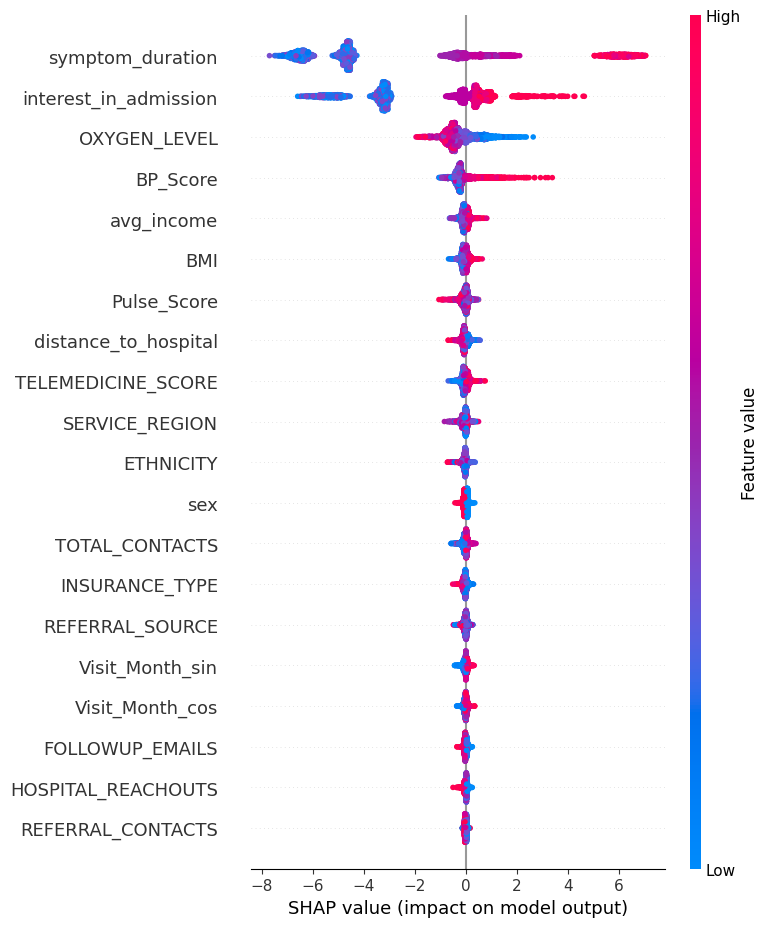

In [70]:
# run shap summary plot for XGBoost model
explainer = shap.Explainer(XG)
shap_values = explainer(X_train_enc)
shap.summary_plot(shap_values, X_train_enc)

### SHAP summary plot and explanation

The SHAP summary plot is a detailed visualization of how each feature influences the model's predictions. The model features are ranked by importance along the y-axis, with symptom_duration, interest_in_admission, and OXYGEN_LEVEL emerging as the top contributors. Each dot on the plot represents a single observation, and the color indicates the features value. The x-axis represents the SHAP value, which quantifies how much a feature pushes a prediction toward positive values or negative values. In this case, hospital admission is positive.

For example, the longer symptom durations push the model's prediction toward a higher likelihood of admission, while shorter durations move toward no admission. Similarly, lower oxygen levels strongly drive predictions toward admission. Features like BP_Score, avg_income, and BMI also show some slight impact. In contrast, categorical and administrative features such as REFERRAL_SOURCE, INSURANCE_TYPE, and TOTAL_CONTACTS have relatively low SHAP values, which indicate minimal influence on the model's output.

Overall, the SHAP plot confirms that the model is leveraging medical indicators and aligns with domain knowledge as we would expect. It enhances model transparency and supports trust in the feature selection and prediction logic.